In [1]:
!pip install tensorflow
!pip install pillow
!pip install scipy

In [2]:
import tensorflow as tf
import os
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from image_utils import split_and_organize_images, create_data_set_from_images
from cnn_builder import CNNBuilder

In [3]:
directories = dict(
    src="../data",
    output=r"c:\temp\imagenet224"
)

src_image_path = Path(os.path.join(os.getcwd(), directories["src"]))
output_path = Path(directories["output"])
split_and_organize_images(src_image_path, output_path, max_workers=8)

In [4]:
training_set = create_data_set_from_images(os.path.join(directories["output"], "train"))
test_set = create_data_set_from_images(os.path.join(directories["output"], "test"))

Found 10311 images belonging to 10 classes.
Found 2944 images belonging to 10 classes.


In [5]:
builder = CNNBuilder()
builder.add_input(kernel_size=7)
builder.add_max_pool()
builder.add_convolution(filters=192, kernel_size=3, strides=(1, 1))
builder.add_max_pool()
builder.add_dropout(0.4)
builder.add_flatten()
builder.add_output_layer(10, activation="softmax")

model = builder.build()
print(model.summary())

C:\src\my\uwf-idc6146-deep-learning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 109, 109, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 55, 55, 192)    │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │     1,505,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,546 (6.20 MB)

 Trainable params: 1,625,546 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
training_result = model.fit(x=training_set, validation_data=test_set, epochs=25)

Epoch 1/25
323/323 ━━━━━━━━━━━━━━━━━━━━ 156s 479ms/step - accuracy: 0.7485 - loss: 0.1390 - val_accuracy: 0.5757 - val_loss: 0.2377
Epoch 2/25
323/323 ━━━━━━━━━━━━━━━━━━━━ 158s 488ms/step - accuracy: 0.7449 - loss: 0.1386 - val_accuracy: 0.5730 - val_loss: 0.2339
Epoch 3/25
323/323 ━━━━━━━━━━━━━━━━━━━━ 156s 478ms/step - accuracy: 0.7411 - loss: 0.1417 - val_accuracy: 0.5720 - val_loss: 0.2290
Epoch 4/25
323/323 ━━━━━━━━━━━━━━━━━━━━ 153s 470ms/step - accuracy: 0.7583 - loss: 0.1366 - val_accuracy: 0.5768 - val_loss: 0.2232
Epoch 5/25
323/323 ━━━━━━━━━━━━━━━━━━━━ 155s 475ms/step - accuracy: 0.7665 - loss: 0.1329 - val_accuracy: 0.5724 - val_loss: 0.2372
Epoch 6/25
323/323 ━━━━━━━━━━━━━━━━━━━━ 155s 476ms/step - accuracy: 0.7598 - loss: 0.1339 - val_accuracy: 0.5819 - val_loss: 0.2258
Epoch 7/25
323/323 ━━━━━━━━━━━━━━━━━━━━ 154s 473ms/step - accuracy: 0.7722 - loss: 0.1311 - val_accuracy: 0.5727 - val_loss: 0.2256
Epoch 8/25
323/323 ━━━━━━━━━━━━━━━━━━━━ 153s 471ms/step - accuracy: 0.7750 -

In [11]:
import pickle

with open(r'c:\temp\training_result.pkl', 'wb') as file:
    pickle.dump(training_result, file)

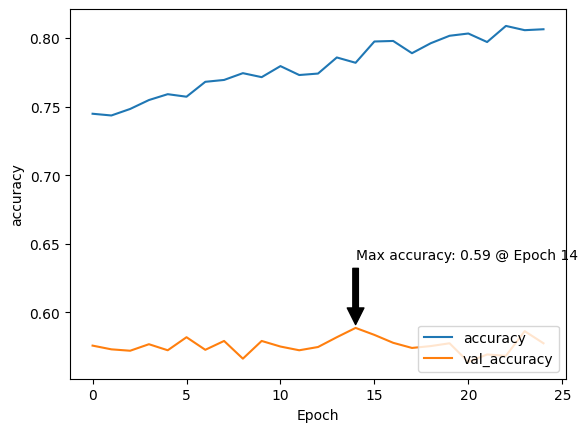

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_curve(training_result):
    ACCURACY_METRIC_NAME = "accuracy"
    VAL_ACCURACY_METRIC_NAME = "val_accuracy"
    
    train_perf = training_result.history[ACCURACY_METRIC_NAME]
    validation_perf = training_result.history[VAL_ACCURACY_METRIC_NAME]
    
    plt.plot(train_perf, label=ACCURACY_METRIC_NAME)
    plt.plot(validation_perf, label=VAL_ACCURACY_METRIC_NAME)
    
    max_val_accuracy = max(validation_perf)
    max_val_accuracy_epoch = validation_perf.index(max_val_accuracy)
    
    plt.annotate(f"Max accuracy: {max_val_accuracy:.2f} @ Epoch {max_val_accuracy_epoch}",
                 xy=(max_val_accuracy_epoch, max_val_accuracy),
                 xytext=(max_val_accuracy_epoch, max_val_accuracy + 0.05),
                 arrowprops=dict(facecolor="black", shrink=0.05))
    
    plt.xlabel("Epoch")
    plt.ylabel(ACCURACY_METRIC_NAME)
    plt.legend(loc="lower right")
    
plot_accuracy_curve(training_result)

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [38]:
validation_set = create_data_set_from_images(os.path.join(directories["output"], "val"))
validation_predictions = model.predict(validation_set)

Found 1483 images belonging to 10 classes.


C:\src\my\uwf-idc6146-deep-learning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step
